# Tutorials

## Introduction to molecular simulations

\[12/03/2025\]

Before we start, some general advise about the way to organize your
work:

-   use simple **virtual environments** for Python packages
-   keep track of **compilation** steps for C/C++/Fortran codes
-   store code / data for **different projects** in **different
    folders**
-   **refactor reusable code** as separate modules / packages

Suggestions:

-   **Fortran+Python** is recommended programming language combo -
    **numba** is ok, too
-   *consider* using **jupyter** or **org-mode** notebooks to document
    your work and workflow
-   later on, *consider* using **git** to version-control your
    simulation codes - probably not your data, though

### The molecular simulations ecosystem

**Simulation packages**: [LAMMPS](https://www.lammps.org/),
[GROMACS](https://www.gromacs.org/),
[HOOMD](https://glotzerlab.engin.umich.edu/hoomd-blue/), ...

-   massively parallel
-   GPU acceleration
-   focus on MD, less on MC

**Simulation frameworks**: [ASE](https://wiki.fysik.dtu.dk/ase/),
[OpenMM](https://openmm.org/), [PLUMED](https://plumed.org),
[atooms](https://framagit.org/atooms/atooms), ...

-   high-level management of simulation objects
-   develop algorithm on top of existing packages
-   abstract out details about simulation backends

Traditional **structure of a simulation code**:

-   *Setup*: initial configuration, interaction model, ...
-   *Simulation*: equilibration vs. production
-   *Analysis*: post-processing vs. on-the-fly calculations


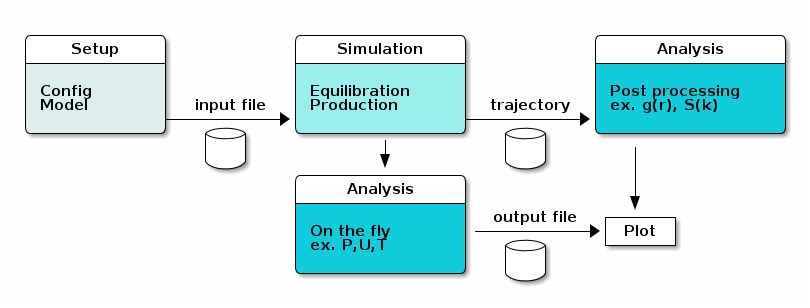

Several stand-alone **setup** and **post-processing** codes, including
**visualization,** are freely available too.

The typical workflow from the command line may look like


In [ ]:
! ./initialize.x < init.inp
! ./simulate.x < sim.inp > sim.out
! ./analyze.x < ana.inp

This is how a typical input script for `LAMMPS` looks like
(say `melt.inp`)


In [ ]:
! # 3d Lennard-Jones melt
! units           lj
! atom_style      atomic
! 
! # Setup
! lattice         fcc 0.8442
! region          box block 0 10 0 10 0 10
! create_box      1 box
! create_atoms    1 box
! mass            1 1.0
! velocity        all create 3.0 87287
! 
! # Interaction parameters
! pair_style      lj/cut 2.5
! pair_coeff      1 1 1.0 1.0 2.5
! 
! # Simulation parameters
! neighbor        0.3 bin
! neigh_modify    every 20 delay 0 check no
! fix             1 all nve
! 
! # Run the simulation and write thermodynamic data on the fly
! thermo          50
! run             250

To setup the system and run the simulation (we assume the executable is
`./lammps`)


In [ ]:
! ./lammps < melt.inp

Most modern packages offer a native Python interface to run the
simulation - that\'s how a `hoomd` script would like, for
instance:


In [ ]:
import hoomd

gpu = hoomd.device.GPU()
sim = hoomd.Simulation(device=gpu, seed=1)
mc = hoomd.hpmc.integrate.ConvexPolyhedron()
mc.shape['octahedron'] = dict(vertices=[
    (-0.5, 0, 0), (0.5, 0, 0),
    (0, -0.5, 0), (0, 0.5, 0),
    (0, 0, -0.5), (0, 0, 0.5)])
sim.operations.integrator = mc
sim.create_state_from_gsd(filename='init.gsd')
sim.run(100e6)

### Getting ready

Today, we will deal with a typical use case: **adapt, wrap and run a
third party simulation code**. We will use the reusable libraries
provided by Allen & Tildesley, written in Fortran and available on their
[code repository](https://github.com/Allen-Tildesley), to carry out a
first Monte Carlo (MC) simulation of a **fluid of hard spheres**. In a
second stage, we will wrap their Fortran code with
[f2py-jit](https://coslo.frama.io/f2py-jit/).

Clone the Allen-Tildesley code repository


In [ ]:
! git clone https://github.com/Allen-Tildesley/examples.git allen_tildesley

It contains both Fortran and Python codes. A detailed guide to use their
codes is available
[here](https://github.com/Allen-Tildesley/examples/blob/master/GUIDE.md).
We will look for the codes relevant for the simulation of a hard sphere
fluid. For the moment, we do not care much about how the simulation code
does what it does - we just want to make it run!

We will also need `f2py-jit` to wrap the Fortran code in
Python. Note that `numpy` version 2 still has some problems
with the Allen-Tildesley code, so we stick to version 1. Run this
command in your virtual environment.


In [ ]:
! pip install numpy~=1.26
! pip install f2py-jit

Later on, we will use a Python package called `argh` to
create a command-line interface for our simulation driver, so let\'s
install it


In [ ]:
! pip install argh

This is a self-contained `requirements.txt` file to set up a
minimal working environment


****Conf****: numpy\~=1.26 f2py-jit argh


### A first Monte Carlo simulation

We\'ll first use their code as it is. To compile it, you can use the
`scons` tools they suggest or look at the
`SContruct` file to understand which Fortran files to grab
and compile. We\'ll need one main file and several modules.

Two steps here:

-   **setup**: setup the initial configuration
-   **simulation**: run the Monte Carlo simulation

These are the files we need to **set up the initial configuration**

-   `config_io_module.f90`
-   `initialize_module.f90`
-   `initialize.f90`

Copy them files in a separate folder, say `hard_spheres/`.


In [ ]:
! mkdir -p hard_spheres
! cp allen_tildesley/{config_io_module,initialize,initialize_module}.f90 hard_spheres/

****Note****: The above command will only work with the
`bash`{.verbatim} shell. If it does not work, just copy each file
individually.


More in detail:

-   `config_io_module.f90`: module to deal with I/O (ex.:
    reading/writing configurations to file)
-   `initialize_module.f90`: module with subroutines to set
    up the initial configuration (ex.: fcc lattice, random configuration
    without overlaps)
-   `initialize.f90`: main program to produce an initial
    configuration

These are the files we need instead to **run the Monte Carlo
simulation** for hard spheres.

-   `maths_module.f90`
-   `averages_module.f90`
-   `mc_hs_module.f90`
-   `mc_nvt_hs.f90`


In [ ]:
! cp allen_tildesley/{maths_module,averages_module,mc_hs_module}.f90 hard_spheres/
! # Main file
! cp allen_tildesley/mc_nvt_hs.f90 hard_spheres/

More in detail:

-   `maths_module.f90`: subroutines for maths, random
    numbers, order parameters
-   `averages_module.f90`: module to compute averages on the
    fly and write them to file
-   `mc_hs_module.f90`: subroutines need for MC simulations
    of hard spheres (ex.: find overlaps between hard spheres)
-   `mc_nvt_hs.f90`: main driver code for MC simulations of
    hard spheres

We can now compile the code...


In [ ]:
! cd hard_spheres/
! gfortran -o initialize.x config_io_module.f90 maths_module.f90 initialize_module.f90 initialize.f90

... and initialize the system


In [ ]:
! echo '&nml /' | ./initialize.x

```
initialize
Compiler: GCC version 11.4.0
Options:  -mtune=generic -march=x86-64 -fpre-include=/usr/include/finclude/math-vector-fortran.h

Sets up initial configuration file for various simulations
Options for molecules are "atom", "linear", "nonlinear", "chain"
Particle mass m=1 throughout
Atoms
nc =                                                 4
n =                                                256
No velocities option selected
Periodic boundary conditions
Density                                       0.750000
Box length                                    6.988644
Close-packed fcc lattice positions
Writing configuration to filename cnf.inp
```

Now we have a `cnf.inp` that looks like this


In [ ]:
! head -n 5 cnf.inp

To change the default parameters, add values to the namelist (look for
the `NAMELIST` line in `initialize.f90`)


In [ ]:
! echo '&nml density=0.7, nc=3 /' | ./initialize.x

or store the namelist in a file and redirect it to
`./initialize.x` on the command line


In [ ]:
! ./initialize.x < init.inp

Now, let\'s **compile the Monte Carlo code**


In [ ]:
! gfortran -O3 -ffast-math -o mc_nvt_hs.x config_io_module.f90 averages_module.f90 \
! 	 maths_module.f90 mc_hs_module.f90 mc_nvt_hs.f90

Run a simulation making 10 \"blocks\" of 1000 MC steps (each MC step is
$N$ attempted MC moves, where $N$ is the number of particles)


In [ ]:
! echo '&nml nblock=10, nstep=1000 /' | ./mc_nvt_hs.x

```
mc_nvt_hs
Compiler: GCC version 11.4.0
Options:  -mtune=generic -march=x86-64 -O3 -ffast-math -fpre-include=/usr/include/finclude/math-vector-fortran.h

Monte Carlo, constant-NVT
Hard sphere potential
Diameter, sigma = 1
Energy, kT = 1
Number of blocks                                    10
Number of steps per block                         1000
Maximum displacement                          0.150000
Pressure scaling parameter                    0.005000
Number of particles                                256
Simulation box length                         6.988644
Density                                       0.750000
Initial values
P                                             0.750000


Run begins
Date:                                       2025/03/11
Time:                                         15:20:28
CPU time:                                     0.012774

===============================================
          Block            Move               P
                          ratio                
-----------------------------------------------
              1        0.322203        4.953711
              2        0.316750        4.980078
              3        0.314012        4.950195
              4        0.318613        4.939062
              5        0.317141        4.962500
              6        0.316461        4.986133
              7        0.312551        4.938867
              8        0.313324        5.005664
              9        0.314320        4.934570
             10        0.316699        4.920507
-----------------------------------------------
   Run averages        0.316207        4.957129
     Run errors        0.000856        0.007934
===============================================

Run ends
Date:                                       2025/03/11
Time:                                         15:20:33
CPU time:                                     4.434334


Final values
P                                             5.046875
Program ends
```

The code is pretty efficient: a typical \"good\" performance for a
**sequential molecular simulation code** is of the order of
$10^{-6} s/(\text{steps} \times N)$ - the actual performance depends on
the thermodynamic state and many other details.


In [ ]:
f'{4.4 / (256 * 10000):.2g} seconds/step/particle'

### Wrapping the Allen-Tildesley code with f2py-jit

The Allen-Tildesley code is efficient and pretty easy to reuse. As it
stands, however, it has a few shortcomings...

Concerning the interface:

-   input parameters handling via **namelists** is a bit awkward,
    especially from the command line
-   handling **I/O** is cumbersome in Fortran (although one can use /
    adapt their Python code)

Concerning the code:

-   it is partly **hard-coded** for 3 dimensions (what if we want to
    simulate hard disks or hyper-spheres?)
-   it uses **global variables**: it would be better to encapsulate them
    (ex. via classes)
-   system variables are **scattered** between modules and main code
-   it uses **single precision**: it would be better to switch to double
    precision
-   some variables are **redundant** (ex. the number of particles
    `n` should be inferred from position array)

Our goal is to replace this main code with a **Python driver** (or
\"entry-point\") to make it easier to control the simulation, change its
parameters, write the results to file, etc. The results of the Python
driver can be

-   trajectory or output files (\"artifacts\")
-   a dictionary of output variables


In [ ]:
def run(input_file='', nsteps=0):
    # run the simulation for nsteps
    # write trajectory file
    # optionally return a dictionary of results
    return {}

This approach enables us to run the simulation workflow both from the
command line as before (by wrapping the entry point using
`argh`) and at a *higher level* directly from Python. The
setup stage and on-the-fly analysis may then pass around their results
directly *within* Python, possibly caching them through a workflow
manager (note the gray IO items in the diagram below - more on this
later).


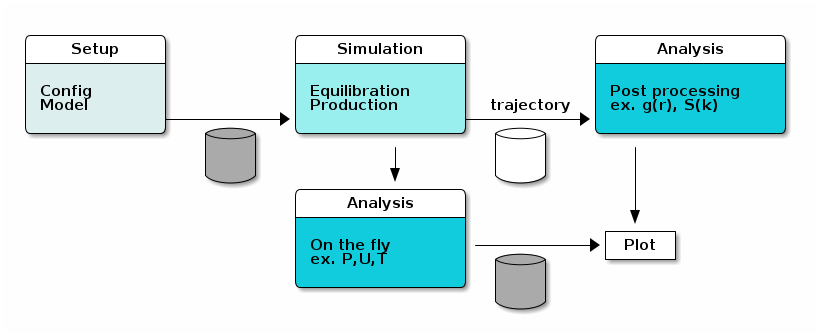

We start by copying the relevant files in a new folder, where we will
develop our wrapper code


In [ ]:
! cd ../
! mkdir -p hard_spheres_wrap/
! cp allen_tildesley/{maths_module,mc_hs_module,mc_nvt_hs}.f90 hard_spheres_wrap/
! cd hard_spheres_wrap/

We will use `f2py-jit` to wrap the `mc_hs_module`
and call its main subroutines. We would like to compile the code like
this...


In [ ]:
import os
from f2py_jit import jit

# Compile the relevant modules for hard spheres
f90 = jit(['maths_module.f90', 'mc_hs_module.f90')], flags='-O3 -ffast-math')

...but hold on! Before doing that, we\'ll have to fix an issue with
array indexing in `maths_module.f90`: there is a
`(0:)` array in `polyval`, which does not play
nice with `f2py` (at least with my setup). These are the
diffs to apply:


****Conf****: 910c910 \< REAL, DIMENSION(0:), INTENT(in) :: c ! given
coefficients (ascending powers of x) --- \> REAL, DIMENSION(:),
INTENT(in) :: c ! given coefficients (ascending powers of x)
916,917c916,919 \< f = c(UBOUND(c,1)) \< DO i = UBOUND(c,1)-1, 0, -1 ---
\> ! f = c(UBOUND(c,1)) \> ! DO i = UBOUND(c,1)-1, 0, -1 \> f =
c(SIZE(c,1)) \> DO i = SIZE(c,1), 1, -1 934c936 \< REAL, DIMENSION(0:4),
PARAMETER :: g = 1.0 / \[1,6,120,5040,362880\] --- \> REAL,
DIMENSION(5), PARAMETER :: g = 1.0 / \[1,6,120,5040,362880\] 957c959 \<
REAL, DIMENSION(0:4), PARAMETER :: g = 1.0 / \[1,6,120,5040,362880\] ---
\> REAL, DIMENSION(5), PARAMETER :: g = 1.0 / \[1,6,120,5040,362880\]


You can edit the lines directly in the code, or apply the patch by first
storing the lines above in a file (say `maths_module.patch`)
and then executing the command


In [ ]:
! patch maths_module.f90 maths_module.patch

We patched the code and we are (almost) ready to go! Check that the code
is compiled correctly now


In [ ]:
import os
from f2py_jit import jit

# Compile the relevant modules for hard spheres
f90 = jit(['maths_module.f90', 'mc_hs_module.f90'], flags='-O3 -ffast-math')

We\'ll also need an **initial configuration** in a format suitable for
the Allen-Tildesley code. We grab the one we used to start the other
simulation


In [ ]:
! cp ../hard_spheres/cnf.inp .

To read the initial configuration we have two options:

1.  wrap the `config_io_module` Fortran module and use its
    subroutine `read_cnf_atoms()`
2.  use the `read_cnf_atoms()` Python function provided in
    `allen_tildesley/python_examples/config_io_module.py`

We\'ll follow route 2.


In [ ]:
! cp ../allen_tildesley/python_examples/config_io_module.py .

The actual Monte Carlo simulations is done in the main program
`mc_nvt_hs.f90.` As a final touch, we encapsulate the task of
performing some Monte Carlo steps in a standalone `run`
subroutine. We create a separate module for this subroutine, say
`mc_hs_driver.f90.`


```
MODULE mc_driver

  USE maths_module, ONLY : random_translate_vector
  USE mc_module, ONLY: overlap_1, r

  IMPLICIT NONE

  REAL :: box         ! Box length
  REAL :: dr_max      ! Maximum MC displacement

CONTAINS

  SUBROUTINE run(nsteps)
    INTEGER, INTENT(in) :: nsteps
    INTEGER :: i, step, moves
    REAL :: ri(3), acc_ratio
    ! This may be done once at the beginning
    ! Convert positions to box units and PBC
    r(:,:) = r(:,:) / box
    r(:,:) = r(:,:) - ANINT(r(:,:))
    ! Do nsteps MC steps
    moves = 0
    DO step = 1, nsteps
       DO i = 1, SIZE(r, 2)
          ri(:) = random_translate_vector(dr_max/box, r(:,i))
          ri(:) = ri(:) - ANINT(ri(:))
          IF (.NOT. overlap_1(ri, i, box)) THEN
             r(:,i) = ri(:)
             moves  = moves + 1
          END IF
       END DO
    END DO
    acc_ratio = REAL(moves) / (nsteps * SIZE(r, 2))
    ! Convert positions back to natural units
    r(:,:) = r(:,:) * box
  END SUBROUTINE run

END MODULE mc_driver
```


Here is the Python wrapper. We make a test ride


In [ ]:
import os
from f2py_jit import jit
from config_io_module import read_cnf_atoms

# Compile the relevant modules for hard spheres
f90 = jit(['maths_module.f90', 'mc_hs_module.f90', 'mc_hs_driver.f90'],
          flags='-O3 -ffast-math')

# Read the input file, this will allocate the arrays too
n, box, r = read_cnf_atoms('./cnf.inp')

# Set the positions in mc_module
f90.mc_module.r = r.transpose()
# Set also the number of particles, n
f90.mc_module.n = n
# Set the remaining parameters in mc_driver
f90.mc_driver.box = box
f90.mc_driver.dr_max = 0.1

# Make nsteps MC steps (each one comprises N attempted moves)
nsteps = 10
for step in range(nsteps):
    f90.mc_driver.run(1000)

*It works!* Of course, we are not sure yet that the simulation is
correct - that should be checked by measuring some physical quantities
and comparing them to some reference values (ex. the ones produced by
the original code). We will do it in the lab session. But at least we
have a working Python driver to carry out MC simulations for hard
spheres.

It is easy now to write a simulation **driver** (\"entry point\")
exposing the main simulation parameters, which can be easily controlled
via workflow managers or from the command line via `argh`.

This is a self-contained, minimal driver - we save it as
`hs_mc_run.py`


In [ ]:
import os
from f2py_jit import jit
from config_io_module import read_cnf_atoms

# Compile the relevant modules for hard spheres
f90 = jit(['maths_module.f90', 'mc_hs_module.f90', 'mc_hs_driver.f90'],
          flags='-O3 -ffast-math')

def run_nvt_hs(input_file='./cnf.inp', nsteps=1, dr_max=0.1):
    n, box, r = read_cnf_atoms(input_file)
    f90.mc_module.r = r.transpose()
    f90.mc_module.n = n
    f90.mc_driver.box = box
    f90.mc_driver.dr_max = dr_max
    for step in range(nsteps):
        f90.mc_driver.run(10000)

# Include these lines only if you want to execute the code from the command line
if __name__ == '__main__':
    import argh
    argh.dispatch_command(run_nvt_hs)

****1****: Write the final configuration at the end of the simulation in
the same format as the input one, to be able to start a new simulation
from a previous one.


****2****: Wrap the `initialize.f90`{.verbatim} main code, along with
its modules, and provide a Python entry point `initialize()`{.verbatim},
similar to `run_nvt_hs()`{.verbatim}.


****3****: Add or wrap the missing bits of the main program
`mc_nvt_hs.f90`{.verbatim} in the driver: initial check for overlaps,
accumulate averages and acceptance ratios, ...


## Object-oriented programming for molecular simulations

\[02/04/2025\]

**Key concepts**:

-   class = data + functions (or \"attributes\" + \"methods\")
-   objects are instances of a class
-   aggregation (\"has a\"), inheritance (\"is a\")

**References**:

-   [Real Python tutorial on object-oriented
    programming](https://realpython.com/python3-object-oriented-programming/)
-   [\"Object-Oriented Analysis and
    Design\"](https://archive.org/details/objectorientedan0000deac/), J.
    Deacon
-   [\"Python 3 Object Oriented
    Programming\"](https://github.com/PacktPublishing/Python-3-Object-Oriented-Programming-Third-Edition), D.
    Phillips

### Object-orientation in a nutshell

In the [procedural
programming](https://en.wikipedia.org/wiki/Procedural_programming)
paradigm, the basic computing units are **functions** operating on
**variables**. Functions can call each other and variables can be
gathered into data structures.

In the
[object-oriented](https://en.wikipedia.org/wiki/Object-oriented_programming)
(OO) programming paradigm, objects *bundle* together **variables**
(\"attributes\") and **functions** (\"methods\"). The specification of
which attributes are attached to a specific object and how methods
operate on them is provided by a **class**: individual objects are
\"instances\" of a specific class.

Python takes object-orientation very seriously: almost everything is an
object in Python (even functions are...!).

Create a float object (`1.0`) and define a name
(`x`) bound to it


In [ ]:
x = 1.0

The object has attributes: get the real part


In [ ]:
x.real

It has methods too: get the complex conjugate


In [ ]:
x.conjugate()

List of attributes and methods


In [ ]:
dir(x)

****Note****: What are all these methods with double leading
underscores? They are \"dunder methods\" (or \"magic methods\"). Some of
them are always there by default in all Python objects. More on them
later on.


It is practical to represents classes with **Unified Modeling Language
(UML) diagrams**.


****Plantuml****: \@startuml []{#defaults_uml} class Float {
+conjugate() +real +imag ... } \@enduml




How to draw UML diagrams?

-   [plantuml](https://plantuml.com/) (from text)
-   [py2uml](https://pypi.org/project/py2puml/) (from code)
-   by hand!

To give you an idea, this is an example of the `plantuml`
syntax


```
@startuml
class Float {
 +conjugate()
 +real
 +imag
 ...
}
```

### Procedural vs object-oriented approaches

To discuss the differences between procedural and object-oriented
approaches, we consider the following minimal example: compute some
property of a particle, given its `position` and
`species`. Here come three possible ways to organize the
code.

\(1\) **Procedural programming with local scope**

The function goes in a module (say `system.py`)


In [ ]:
def compute(position, species):
    # do something with input position and species
    pass

Variables are defined in client code


In [ ]:
import system

position = [0.0, 0.0, 0.0]
species = 'Ar'
system.compute(position, species)

\(2\) **Procedural programming with global scope**

Variables are global in the module and we provide an entry point in the
module


In [ ]:
position = [0.0, 0.0, 0.0]
species = 'Ar'

def compute():
    # do something with (global) position and species
    pass

Client code


In [ ]:
import system
system.compute()

\(3\) **Object-oriented programming**

Variables and functions are \"encapsulated\" in an object. In the
`system` module we have


In [ ]:
class System:

    def __init__(self):
        self.position = [0.0, 0.0, 0.0]
        self.species = 'Ar'

    def compute(self):
        # do something with self.position and self.species
        pass

Client code


In [ ]:
from system import System

system = System()
system.compute()

****Question****: What are the pros and cons of each of these
approaches?


****Warning****: Even though object-orientation is an elegant and
widespread programming model, it is not necessarily the way to go for
any given computational problem. Kenneth Reisz [put it
down](https://docs.python-guide.org/writing/structure/#object-oriented-programming)
very nicely.


### Object-oriented analysis and design

How do we choose *objects*, *attributes*, *methods*? This is the core
question of [object-oriented analysis and
design](https://en.wikipedia.org/wiki/Object-oriented_analysis_and_design).
See for instance [\"Object-Oriented Analysis and
Design\"](https://archive.org/details/objectorientedan0000deac/) by J.
Deacon for an introduction.


****Guideline****: (1) Start with a **narrative description** of the
**subject matter**


This is a possible narrative description of classical molecular
simulations:

\"Our **system** of interest *is composed* of several **particles** in 3
**dimensions**, possibly *enclosed* in an orthorombic **cell** of given
**sides** with **periodic boundary conditions** at the surface. Each
particle *has* some **mass**, *is located* at a given **position** and
it may *move* at some **velocity**. Each particle *is* of a given
chemical **species**. The system may *be in contact* with one or more
**reservoirs**, such as a **thermostat** (at fixed **temperature**), a
**barostat** (at fixed **pressure**) and a **particle reservoir** (at
fixed **chemical potential**). We can *compute* the **interaction**
between the particles of the system, to *get* the system\'s total
**potential energy** and total **virial**.\"

Key points:

-   **nouns** are candidates for *objects* or *attributes*
-   **verbs** are candidates for *methods* or *object relationships*

Here is a basic UML diagram of the system components, highlighting only
some of the attributes and methods identified above.


****Plantuml****: \@startuml []{#defaults_uml}

class System { temperature +compute() +potential~energy~() +virial() ...
} class Cell { side periodic ... } class Thermostat { temperature ... }
class Barostat { pressure ... } class Particle { position velocity mass
species ... }

System o-- \"many \" Particle System o-- \" 0..1\" Cell System o--
\"0..1\" Thermostat System o-- \"0..1 \" Barostat \@enduml


****Guideline****: (2) Always use **expressive** and **spelled-out**
names for objects\' attributes and methods


Object-oriented programming really shines when it provides a
**high-level description** of the subject matter: let the code \"speak\"
as you would!

Good:


In [ ]:
particle = Particle(position=[1.0, 0.0, 0.0])
system = System([particle])
system.potential_energy(per_particle=True)

OK too:


In [ ]:
p = Particle(position=[1.0, 0.0, 0.0])
s = System([p])
s.potential_energy(per_particle=True)

Not good:


In [ ]:
p = Part(r=[1.0, 1.0, 1.0])
s = Syst([p])
s.Epot(norm=True)

****Guideline****: (3) Use **singular** names for classes


For instance, use `Particle`, not `Particles`. See
the discussion about [*AoS vs. SoA*]{.spurious-link
target="Arrays of structures vs. structures of arrays"} below for
exceptions.


****Guideline****: (4) **Revise**, **enrich** or **strip down** your
initial design as you progress in writing the code


You may decide, for instance, to simplify your design for efficiency
reasons or convenience.

### Constructors, dunders and other methods

In the following, we will illustrate some basic concepts of
object-oriented programming using the main object of interest in
classical molecular simulations: the particle. A good reference on
object-oriented programming in Python is [\"Python 3 Object Oriented
Programming\"](https://github.com/PacktPublishing/Python-3-Object-Oriented-Programming-Third-Edition)
by D. Phillips.

Each object in Python has some [magic or \"dunder\"
methods](https://docs.python.org/3/reference/datamodel.html#special-method-names).
The `__init__()` method is an example: it is used to
construct an object (this method is called \"constructor\" in the OO
paradigm).


In [ ]:
import numpy

class Particle:

    def __init__(self, position, velocity=None, species='Ar', mass=1.0):
        self.position = numpy.asarray(position)
        if velocity is not None:
            self.velocity = numpy.asarray(velocity)
        else:
            self.velocity = numpy.zeros(len(position))
        self.species = species
        self.mass = mass

The `self` variable refers to the specific object instance we
are about to create and whose attributes we want to set or modify. It
must be passed as first argument to any method. The name
`self` is a convention.


****Note****: Python does not require you to specify the type of the
arguments accepted by a function, even though this is possible since
Python 3.5 with *type annotations*. However, I think this goes against
the basic principles and advantages of the Python language. I share the
criticisms expressed by Guillaume Pasquet in [this blog
post](https://dev.to/etenil/why-i-stay-away-from-python-type-annotations-2041).


We create an object of the `Particle` class and access its
attributes with the dot syntax (which we already encountered)


In [ ]:
particle = Particle([0.0, 0.0, 0.0])
print(particle.position, particle.species, particle.mass)

****Warning****: In functions, never use [default values for mutable
arguments](https://stackoverflow.com/questions/1132941/least-astonishment-and-the-mutable-default-argument)!
Assign instead the special object `None`{.verbatim} as default and deal
with the optional argument in the body of the function.


In other OO programming languages, one often needs to define a
\"destructor\" method too, to deallocate memory associated with the
object. This is not necessary in Python, which has built-in garbage
collection, but can be done explicitly if needed with the
`__del__()` method.


In [ ]:
    def __del__(self):
        # clean up here

Dunder methods can be used to extend functionalities of objects in many
different ways, we will illustrate one of them below.

So far, we mostly worked with attributes. Methods describe an \"action\"
that a concrete instance of a class can \"do\". As a fancy example, we
will introduce a method that describe the disintegration of the
particle. The `disintegrate()` method will take care of

-   creating and returning an additional particle
-   subtracting the mass of the new particle from the current one


In [ ]:
import numpy

class Particle:

    def __init__(self, position, velocity=None, species='Ar', mass=1.0):
        self.position = numpy.asarray(position)
        if velocity is not None:
            self.velocity = numpy.asarray(velocity)
        else:
            self.velocity = numpy.zeros(len(position))
        self.species = species
        self.mass = mass

    def disintegrate(self):
        # Create a new particle with half the mass of this one
        new = Particle()
        new.mass = self.mass / 2
        self.mass -= new.mass
        return new

****Warning****: Hey! Shouldn\'t we conserve the total momentum too?


We add this public method to the UML diagram


****Plantuml****: \@startuml []{#defaults_uml}

class Particle { +position: Array +velocity: Array +mass: float
+disintegrate(): Particle } \@enduml




### Association, aggregation, composition

The relationship between objects can be of different types (from the
weakest to the strongest):

-   **association**: object A *uses* object B
-   **aggregation**: object A *has* object B
-   **composition**: object A *owns* object B

In UML diagrams, we use

-   simple arrow (→) for association
-   empty diamond (◇) for aggregation
-   full diamond (◆) for composition

The difference between aggregation and composition is about being
*exclusive* or not:

-   aggregation allows object B to exist independent of object A: if A
    ceases to exist, B may still exist
-   composition does not allow object B to exist on its own

**Example 1**: a university can be seen as a composition of departments,
whereas departments are an aggregation of professors.

**Example 2**: a teaching department is composed of master programs,
each master program aggregates students and professors.

This is the relationship between programs and departments: the program
ceases to exist if the department disappears (**composition**). A master
program aggregates students and professors (**aggregation**): hopefully,
they do not cease to exist if the master program shuts down.


****Plantuml****: \@startuml []{#defaults_uml} \"Master program\" -up-\*
\"1..\" \"Teaching department\" \"Student\" -up-o \"1.. \" \"Master
program\" \"Professor\" -up-o \" 1..\" \"Master program\" \@enduml




**Association** describes a weaker kind of relationship. While a
professor is always responsible for lectures, PhD students may intervene
during a lecture at some point to describe their research.


****Plantuml****: \@startuml []{#defaults_uml} \"Lecture\" -up-o \"1..\"
\"Master course\" \"Professor\" -up-o \" 1.. \" \"Lecture\" \"PhD
student\" -up-\> \" 0..\" \"Lecture\" \@enduml


****Question****: We write that our system of interest is composed of
$N$ particles. Should the system *have* those particles (aggregation) or
*own* them (composition)?


This diagram describes aggregation of particles into a system


****Plantuml****: \@startuml []{#defaults_uml}

class System { +particle\[\]: Particle +mass(): float } class Particle {
+mass: float } Particle -up-o \"1..\" System \@enduml




Here we create the corresponding `System` class, aggregating
a list of `Particle` objects


In [ ]:
import numpy

class Particle:

    def __init__(self, position, velocity=None, species='Ar', mass=1.0):
        self.position = numpy.asarray(position)
        if velocity is not None:
            self.velocity = numpy.asarray(velocity)
        else:
            self.velocity = numpy.zeros(len(position))
        self.species = species
        self.mass = mass

class System:

    def __init__(self, particle):
        self.particle = particle

particle = [Particle([0.0, 0.0, 0.0])]
system = System(particle)

In this variant, we compose instead the `System` of
\"private\" particles


In [ ]:
class System:

    def __init__(self, N):
        self.particle = []
        for _ in range(N):
            self.particle.append(Particle([0.0, 0.0, 0.0]))

system = System(1)

****Note****: Should the `particle`{.verbatim} name be plural instead?
That\'s a matter of choice. However, once you choose a convention, it is
better to stick to it.


### Properties: blending attributes and methods

Often you will encounter **methods that look like attributes**: they
describe properties, but they must be recomputed whenever the system
attributes change. If this is the case, consider use the [property
decorator](https://realpython.com/python-property/) to turn these
methods into attributes.

As an example, we consider the kinetic energy of a particle


In [ ]:
    def kinetic_energy(self):
        return 0.5 * self.mass * numpy.sum(self.velocity**2)

Since we need to evaluate the kinetic energy on the basis of the current
velocity, it is quite logical to use a method for that. However,
\"kinetic energy\" sounds more like a particle attribute than a method,
so let\'s turn it into a property


In [ ]:
import numpy

class Particle:

    def __init__(self, position, velocity=None, species='Ar', mass=1.0):
        self.position = numpy.asarray(position)
        if velocity is not None:
            self.velocity = numpy.asarray(velocity)
        else:
            self.velocity = numpy.zeros(len(position))
        self.species = species
        self.mass = mass

    @property
    def kinetic_energy(self):
        return 0.5 * self.mass * numpy.sum(self.velocity**2)

This way we can access the kinetic energy as an attribute, but its value
is calculated dynamically


In [ ]:
particle = Particle([0.0, 0.0, 0.0])
particle.kinetic_energy

In [ ]:
particle.velocity[:] = [1.0, 0.0, 0.0]
particle.kinetic_energy

The property decorator allows you to forget about **getters** and
**setters**, which are often used in other OO programming languages.


In [ ]:
class System:

    def __init__(self):
        self._temperature = 0.0

    @property
    def temperature(self):
        print('Get the temperature')
        return self._temperature

    @temperature.setter
    def temperature(self, value):
        print('Set the temperature')
        self._temperature = value

We can then use a more expressive language


In [ ]:
system = System()
system.temperature = 1.0
print(system.temperature)

****Warning****: Using properties may not *always* be a good idea. For
instance, if your \"getter\" method accepts some arguments, a property
would not work.


### Arrays of structures vs. structures of arrays

Our physical system is a composed of particles (in the sense of
aggregation). We can thus pass our `System` a list of
`Particle` objects at construction


In [ ]:
# Cells per side
M = 2
# Lattice spacing
a = 1.0

# Build a cubic crystal
particle = []
for i in range(M):
    for j in range(M):
        for k in range(M):
            particle.append(Particle([i*a, j*a, k*a]))
system = System(particle)

This is probably the most natural design for a physical system composed
of classical particles. This kind of data layout is called **array of
structures** (AoS).


In [ ]:
system_aos = system

A different approach is to use a **structure of arrays** (SoA) layout,
instead. We do this by introducing a `Particles` class
describing a collection of particles instead of a single one. This will
break our initial design and provide **less encapsulation**, but it will
almost certainly be **more efficient**. The performance penalty of the
AoS approach can be severe in plain Python - much less so in other
object-oriented languages.


In [ ]:
class Particles:

    def __init__(self, position, species, mass):
        self.position = numpy.asarray(position)
        self.species = numpy.asarray(species)
        self.mass = numpy.asarray(mass)

class SystemSoA:

    def __init__(self, particles):
        self.particles = particles

In [ ]:
position, species, mass = [], [], []
for i in range(M):
    for j in range(M):
        for k in range(M):
            position.append([i*a, j*a, k*a])
            species.append('Ar')
            mass.append(1.0)
particles = Particles(position, species, mass)
system_soa = SystemSoA(particles)

Now all the positions, species and masses are assembled as
`numpy` arrays. To access the particle properties:


In [ ]:
print(system_aos.particle[0].position)
print(system_soa.particles.position[0])

****Note****: The choice between SoA and AoS comes from a trade-off
between efficiency and adherence to OO design principles. In Python,
there are ways to keep the best of the two worlds...!


****Note****: You may consider an even simpler design, in which the
system holds directly the particles\' and cell attributes, ex.
`system.position`{.verbatim}, `system.cell_side`{.verbatim}. This flat
design provides *even less* encapsulation but may be a better starting
point for your code. It would also adhere to the principle \"flat is
better than nested\" of the Zen of Python.


### Inheritance, polymorphism, duck typing

To illustrate the key ideas about inheritance, we will use a different
example related to molecular simulations: the concept of \"trajectory\".
Here is a possible narrative description:

\"A **trajectory** *consists of* a sequence of copies of the **system**
(or **snapshots**) taken during a simulation. Each copy *is identified*
by a progressive **index** (or **frame**) and possibly by the number of
simulation **steps** after which it was taken. Trajectories can be
*written* to and *read* from memory, either on a file or in RAM.\"

Since trajectory files can have different formats, we are ready to
construct a class hierarchy. Trajectories share some **common
attributes** and the **same interface** to read and write frames. This
is defined by the following **base class**.


In [ ]:
class _Trajectory:

    def __init__(self, filename=None, mode='r'):
        self.filename = filename
        self.mode = mode
        self.steps = []

    def read(self, frame):
        """Return the `System` at the given `frame`"""
        system = self._read(frame)
        return system

    def write(self, system, step):
        """Write the `system` at the given `step`"""
        assert self.mode == 'w'
        self._write(system, step)
        self.steps.append(step)

    def _read(self, frame):
        # To be implemented in subclasses
        pass

    def _write(self, system, step):
        # To be implemented in subclasses
        pass

Note that this class does not implement the \"private\" methods
`_read()` and `write()`. This is deferred to
**subclasses**, implementing specific trajectory formats.


****Note****: In Python, there are no truly private attributes or
methods. It is a convention to choose names starting with an underscore
for attributes and methods that are not *supposed* to be accessed or
called by client code. Nothing prevent them to do so, though.


****Note****: In the object-oriented jargon, the
`_Trajectory`{.verbatim} class is classified as an \"abstract\" class,
as it does not provide concrete implementations of some of its methods.
As such, it is not meant to be instantiated on its own, only subclassed.
To emphasize this one can raise a `NotImplementedError`{.verbatim} in
the corresponding methods, or use the
[abc](https://docs.python.org/3/library/abc.html) module.


The following **subclass** *inherits* all the attributes and methods of
the base trajectory and implements a minimal storage mechanism in RAM by
providing concrete implementations of `_write()` and
`_read()` methods.


In [ ]:
import copy

class TrajectoryRAM(_Trajectory):

    def __init__(self, filename=None, mode='w'):
        super().__init__(filename, mode)
        self._system = []

    def _write(self, system, step):
        self._system.append(copy.deepcopy(system))

    def _read(self, frame):
        return copy.deepcopy(self._system[frame])

This is instead a sketch of a trajectory with storage on files in the
Allen-Tildesley format


In [ ]:
import glob

class TrajectoryAllenTildesley(_Trajectory):

    def __init__(self, filename, mode='r'):
        assert mode == 'r', 'cannot write this yet'
        super().__init__(filename, mode)
        self._files = glob.glob(filename)
        self.steps = [int(path.split('.')[-1]) for path in self._files]

    def _read(self, frame):
        path = self._files[frame]
        with open(path) as fh:
            data = fh.read().split('\n')
            N, L = int(data[0]), float(data[1])
            pos = []
            for line in data[2:]:
                pos.append(numpy.array(line.split()), dtype=float)
        system = System()
        # Here you should initialize the system's particles and cell
        return system

The relationship between trajectory classes is summarized by this UML
diagram. Notice the special arrow used to indicate that a subclass
inherits from the base class. We also mark public and private methods
differently in the diagram.


****Plantuml****: \@startuml []{#defaults_uml}

abstract class Trajectory { +steps\[\]: int +read(frame: int)
+write(step: int) } class TrajectoryRAM { -~system~\[\]: System ...
-~read~(frame: int) -~write~(step: int) } class TrajectoryAllenTildesley
{ -~files~\[\]: str ... -~read~(frame: int) -~write~(step: int) }
TrajectoryAllenTildesley -up-\|\> Trajectory TrajectoryRAM -up-\|\>
Trajectory \@enduml




The cool thing is that once the trajectory is constructed, it does not
matter if it is of `TrajectoryRAM` or
`TrajectoryAllenTildesley` type, as they both implement the
*same interface*!


In [ ]:
def analyze(trajectory):
    # post-process the trajectory
    pass

t = TrajectoryAllenTildesley('cfg.*')
analyze(t)
t = TrajectoryRAM()
analyze(t)

Client code works just as well with any type of trajectory format: this
**decouples** the process of reading and writing trajectories from the
rest of the simulation or analysis code.


****Gotcha****: Greet the combined power of **encapsulation** and
**polymorphism**!


Actually, in Python, we do not need classes to inherit from a base class
in order for polymorphism to work: any class that implements the
expected interface (as defined by `_Trajectory,` in this
case) will do fine. This is called **duck typing**: \"*if it walks like
a duck and it quaks like a duck, then it must be a duck*\".


In [ ]:
class SomeOtherTrajectory:

    def __init__(self, filename=None, mode='r'):
        self.filename = filename
        self.mode = mode
        self.steps = []

    def read(self, frame):
        # actually read the system
        return system

    def write(self, system, step):
        assert self.mode == 'w'
        self.steps.append(step)
        # actually write the system

This provides a flexible and lightweight approach to polymorphism.
Actually, whenever possible, it is better to \"favor composition over
inheritance\", as we shall see when we\'ll meet our first [*design
patterns*]{.spurious-link
target="Design patterns for molecular simulations"}.

### Customize objects\' behavior with magic methods

We shall now give the `Trajectory` objects the \"look and
feel\" of file objects by adding the following dunder methods:

1.  `__enter__()`, `__exit()__`: to **open and
    close** trajectories with the `with` syntax
2.  `__len__()`, `__iter__()`: to **iterate** over
    trajectory frames as with lines in a file

We also add a `_close()` method, which can be implemented by
subclasses for instance to close file handles if necessary.


In [ ]:
class _Trajectory:

    def __init__(self, filename=None, mode='r'):
        self.filename = filename
        self.mode = mode
        self.steps = []

    def read(self, frame):
        """Return the `System` at the given `frame`"""
        system = self._read(frame)
        return system

    def write(self, system, step):
        """Write the `system` at the given `step`"""
        assert self.mode == 'w'
        self._write(system, step)
        self.steps.append(step)

    def _read(self, frame):
        # To be implemented in subclasses
        pass

    def _write(self, system, step):
        # To be implemented in subclasses
        pass
    def _close(self):
        # subclasses can implement this, ex. to close file objects
        pass

    def __enter__(self):
        return self

    def __exit__(self, type, value, traceback):
        self._close()

We can now open and close the trajectory like this


In [ ]:
with _Trajectory() as th:
    pass

Here, we assume that the number of frames of the trajectory is equal to
the size of the steps list.


In [ ]:
class _Trajectory:

    def __init__(self, filename=None, mode='r'):
        self.filename = filename
        self.mode = mode
        self.steps = []

    def read(self, frame):
        """Return the `System` at the given `frame`"""
        system = self._read(frame)
        return system

    def write(self, system, step):
        """Write the `system` at the given `step`"""
        assert self.mode == 'w'
        self._write(system, step)
        self.steps.append(step)

    def _read(self, frame):
        # To be implemented in subclasses
        pass

    def _write(self, system, step):
        # To be implemented in subclasses
        pass
    def __len__(self):
        return len(self.steps)

    def __iter__(self):
        for i in range(len(self)):
            yield self.read(i)

We can now iterate of the frames as if the trajectory were a list


In [ ]:
th = _Trajectory()
for system in th:
    pass

****1****: Implement the `TrajectoryAllenTildesley`{.verbatim} class by
returning a `System`{.verbatim} object at each frame.


****2****: Add support to writing frames to file in the
`TrajectoryAllenTildesley`{.verbatim} class.


## Design patterns for molecular simulations

\[03/04/2025\]

Ready to follow the white rabbit?

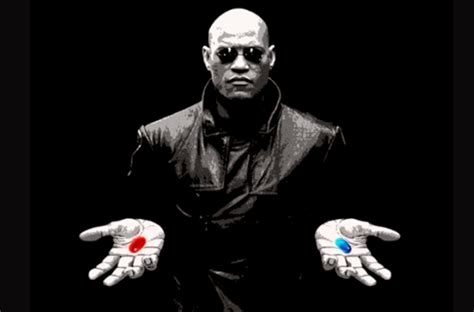

**Key concepts**:

-   Design patterns are \"typical solutions to common problems in
    object-oriented software design\"
-   There are 22 main patterns, first described by the \"Gang of Four\"
    in 1994
-   They can make your simulation code way, **way**, **WAY** more
    flexible

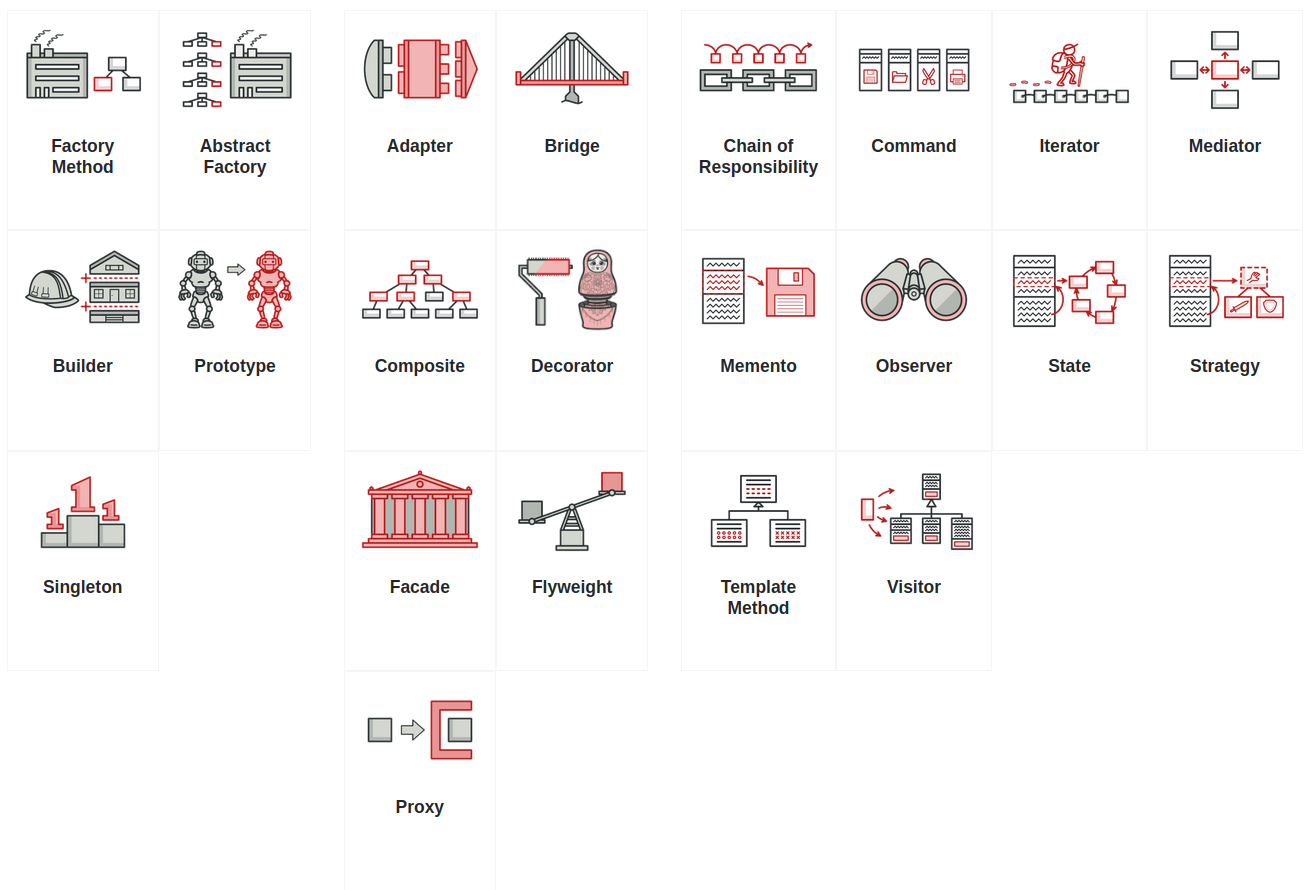

**Design principles**:

-   \"*encapsulate what varies*\"
-   \"*favor composition over inheritance*\"
-   ...

**References**:

-   [\"Design patterns\"](https://en.wikipedia.org/wiki/Design_Patterns)
    by Erich Gamma, Richard Helm, Ralph Johnson, and John Vlissides
-   [\"Head first design
    patterns\"](https://www.oreilly.com/library/view/head-first-design/9781492077992/)
    O\'Reilly book
-   [\"Python 3 Object Oriented
    Programming\"](https://github.com/PacktPublishing/Python-3-Object-Oriented-Programming-Third-Edition), D.
    Phillips
-   [Refactoring guru](https://refactoring.guru/design-patterns) webpage
-   Design patterns [cheat
    sheet](https://github.com/denezt/software-design-patterns/blob/main/Gang_of_Four_23_Design_Patterns_Cheat_Sheet.md)


****Start****: Let\'s think about which tasks are carried out during a
molecular simulation:

-   initialization
-   run the simulation for some steps
-   compute properties on the fly
-   store trajectories on file
-   logging info about simulation


### Singleton: a custom logging system as warm-up

**Intent**: \"*Singleton is a design pattern that lets you ensure that a
class has only one instance, while providing a global access point to
this instance*\".

See <https://refactoring.guru/design-patterns/singleton>


****Plantuml****: \@startuml []{#defaults_uml} class Singleton {
-~instance~: Singleton +instance(): Singleton ... } class Client { }

Client -up-\> Singleton Singleton --\> Singleton \@enduml




Let\'s consider a simple use case for the Singleton pattern: a **logging
system**. We want to design it in such a way that we can turn the change
the verbosity at run time, so that unimportant messages are not printed
when the requested verbosity is low. When changing the verbosity, this
applies to all the code running in the Python session.


****Note****: In Python, there is already a standard module to control
logging: the [logging](https://docs.python.org/3/library/logging.html)
module. But what\'s wrong with reinventing the wheel?


Let us start with the easy stuff. We will add to the `Logger`
class an integer `verbosity` attribute, indicating the
verbosity level, and an `info()` method that client code can
use to log non-critical information: when the verbosity is 0 it will not
be printed at all.


****Plantuml****: \@startuml []{#defaults_uml} class Logger {
-~instance~: Logger +verbosity: int +setup(verbosity: int)
+info(message: str) ... } class Client { }

Client -up-\> Logger Logger --\> Logger \@enduml




We design the `Logger` class following the Singleton pattern.
In Python we do not need a separate accessor to access the unique
private `_instance` of the Singleton class. We can instead
extend the `__new__()` dunder method that creates a new
instance of a class, so that it always returns the same object.


In [ ]:
class Logger:

    _instance = None

    def __new__(cls, *args, **kwargs):
        if not cls._instance:
            cls._instance = super().__new__(cls)
            cls._instance.__init__(*args, **kwargs)
        return cls._instance

    def __init__(self, verbosity=1):
        self.verbosity = verbosity

    def info(self, message):
        if self.verbosity > 0:
            print('INFO:', message)

logger = Logger()
logger.info('hello!')
logger.verbosity = 0
logger.info('hello!')

If we instantiate another logger, we always get the same istance


In [ ]:
new_logger = Logger()
print(logger is new_logger)

This is a different implementation, which does not require messing
around with `__new__()`


In [ ]:
class _Logger:

    def __init__(self):
        self.verbosity = 1

    def info(self, message):
        if self.verbosity > 0:
            print('INFO:', message)

_logger = _Logger()

def Logger():
    return _logger

logger = Logger()
new_logger = Logger()
new_logger.info('hello!')
assert logger is new_logger

Actually, in Python, there is a much simpler implementation of the
Singleton pettern: just use a module! Say we put this code in
`logger.py`


In [ ]:
verbosity = 1

def info(message):
    if verbosity > 0:
        print('INFO:', message)

Then logging in client code can be done like this.


In [ ]:
import logger
logger.info('hello!')

Notice how the \"interface\" is the *same* with both module and class
implementations. However, in the former case logger is not an instance
of a proper class anymore: as such, for instance, the logger cannot be
subclassed.


****Note****: There are many more possible ways to implement Singletons
in Python, see for instance [this stackoverflow
question](https://stackoverflow.com/questions/6760685/what-is-the-best-way-of-implementing-singleton-in-python).


****1****: Add different verbosity levels and methods to log debug
messages (to be displayed when verbosity is high) and critical messages
(to be displayed anyway).


****2****: Define `verbosity`{.verbatim} as a property, so that you can
you use either integer (ex. 0, 1, 2) or string values (ex. \"CRITICAL\",
\"INFO\", \"DEBUG\") to define the verbosity level. The setter method
will convert the string to integer if needed.


### Strategy: a flexible design for simulation algorithms

**Intent**: \"*Defines a family of algorithms, encapsulates each one,
and make them interchangeable. Strategy lets the algorithm vary
independently from clients who use it.*\"

See <https://refactoring.guru/design-patterns/strategy>.


****Plantuml****: \@startuml []{#defaults_uml} class Context { +do()
+strategy ... } abstract class Strategy { +execute() } class
ConcreteStrategy { +execute() ... }

Strategy -up-o Context Strategy \<\|- ConcreteStrategy ConcreteStrategy
\<- Client Client -up-\> Context \@enduml




The **Strategy** pattern follows these two design principles:

-   \"**encapsulate what varies**\": identify the parts of the
    application that change and separate them from what remains the same
-   \"**favor composition over inheritance**\": to add new behavior to a
    class (say `Context`), do not subclass it: aggregate
    instead an instance of another class (say `Strategy`),
    responsible for the new behavior

From [wikipedia](https://en.wikipedia.org/wiki/Strategy_pattern): \"In
the strategy pattern, behaviors are defined as separate interfaces and
specific classes that implement these interfaces. This allows better
decoupling between the behavior and the class that uses the behavior.
The behavior can be changed without breaking the classes that use it,
and the classes can switch between behaviors by changing the specific
implementation used without requiring any significant code changes.
Behaviors can also be changed at run-time as well as at design-time.\"

We illustrate this more explicitly in the context of molecular
simulations. Different kinds of simulations share some common features
(see also below), but typically differ because of the underlying
simulation method:

-   Monte Carlo
-   molecular dynamics
-   stochastic dynamics
-   event-driven dynamics
-   ...

Each of these methods use different simulation algorithms. Moreover,
more complex simulation strategies may combine and/or extend the above
algorithms, for instance to enhance sampling (ex. parallel tempering,
transition path sampling, ...).

We could think of having a base `Simulation` class,
implementing some common parts, and then several client classes
inheriting from it: `MonteCarlo`,
`MolecularDynamics`, ...


****Plantuml****: \@startuml []{#defaults_uml} class Simulation {
+current~step~: int +run(steps: int) ... } class MolecularDynamics { ...
+run(steps: int) } class MonteCarlo { ... +run(steps: int) }

Simulation \<\|-- MolecularDynamics Simulation \<\|-- MonteCarlo
\@enduml




However, this will lead to a complex hierarchy of highly coupled
`Simulation` subclasses. Changes in the base class will
impact the whole hierarchy of subclasses and may produce unwanted,
non-local effects, leading to maintenance issues.

We can instead offload the task of performing the actual simulation to
an instance of a separate class, which provides a specific algorithm
(the \"strategy\") to implement the simulation. By defining a minimal
interface through which `Simulation` and
`Algorithm` interact with one another, we **reduce the
coupling** between diffrent parts of the code.


****Plantuml****: \@startuml []{#defaults_uml} class Simulation {
+run(steps) +algorithm +current~step~ ... } abstract class Algorithm {
+run(steps) } class MolecularDynamics { +run(steps) ... } class
MonteCarlo { +run(steps) ... }

Simulation o-- Algorithm Algorithm \<\|-- MolecularDynamics Algorithm
\<\|-- MonteCarlo \@enduml




This is a minimal implementation in Python


In [ ]:
class Simulation:

    def __init__(self, algorithm):
        """Initialize the simulation and aggregate an `algorithm` to it"""
        self.algorithm = algorithm
        self.current_step = 0

    def run(self, steps):
        """Run the simulation for `steps` iterations"""
        self.algorithm.run(steps)
        self.current_step += steps

class MolecularDynamics:

    def run(self, steps):
        pass

class MonteCarlo:

    def run(self, steps):
        pass

### Observer: extend your simulation code with callbacks

**Intent**: \"*Define a one-to-many dependency between objects so that
when one object changes state, all its dependents are notified and
updated automatically*\".

See <https://refactoring.guru/design-patterns/observer>


****Plantuml****: \@startuml []{#defaults_uml} class Publisher {
+subscribe(s: Subscriber) +unsubscribe(s: Subscriber) +notify()
-~subscribers~: Subscriber\[\] ... } abstract class Subscriber {
+do(context) } class ConcreteSubscriber { +do(context) ... }

Subscriber -up-o Publisher Subscriber \<\|- ConcreteSubscriber
ConcreteSubscriber \<.right. Client Client -up-\> Publisher \@enduml


****Note****: Did you notice the similarity between this UML diagram and
the one of Strategy? The Observer pattern implements again our two main
design principles.


This pattern is very useful in the context of molecular simulations.
Different types of molecular simulations often require some common
tasks, which are executed as the simulation progresses:

-   store properties on disk
-   store trajectory on disk
-   log info about execution
-   check for termination
-   ...

Notice how:

-   each of these tasks is *independent* of the others
-   some of them are *required* while other are *optional*
-   they may be performed just *once* or /regularly and possibly at
    *different intervals*

To handle the situation in the most general way and with the highest
flexibility, we\'ll adapt the **Observer** pattern.

Each of the possible tasks will be named \"**callback**\": a plain
function (or, more generally, a callable) accepting the simulation
itself as first argument and possibly additional arguments. For
instance, a concrete callback may write to disk some thermodynamic
properties. A `Simulation` instance will call the callbacks
through a `Scheduler`. The `Scheduler` may
implement different kinds of \"notification schemes\": at regular
intervals, arbitrary values of steps, periodic blocks, ...

As a first implementation, we assume that the notification scheme is
\"linear\", that is, the scheduler notifies the observers at regular
intervals in units of steps. More general scheduling schemes can easily
be added.


****Plantuml****: \@startuml []{#defaults_uml} class Simulation {
+scheduler: Scheduler }

class Scheduler { +register(c: Callback, interval: int) +notify(s:
Simulation) +int next() -~callbacks~: Callback\[\] -~schedules~: List
... } abstract class Callback { -\_~call~\_~(s:\ Simulation)~ } class
ConcreteCallback { -\_~call~\_~(s:\ Simulation)~ ... }

Scheduler o-right- Simulation Callback -up-o Scheduler Callback \<\|--
ConcreteCallback \@enduml


****Note****: Callbacks can be plain functions in Python. In the above
diagram, we assumed a more general \"callable\" class, that is, a class
with a `__call__()`{.verbatim} method.


This is a minimal implementation


In [ ]:
class Scheduler:

    def __init__(self):
        # Each callback is callable
        self._callbacks = []
        # Each schedule is a scheduling scheme described by a tuple
        # of the format (scheme, params), where scheme is a string
        # and params is a variable with scheduling parameters
        self._schedules = []

    def register(self, callback, interval):
        """Register a `callback` to be called every `interval` number of steps"""
        self._callbacks.append(callback)
        self._schedules.append(("linear", interval))

    def _must_notify(self, schedule, step):
        """Return `True` if we must call callbacks according to `schedule`"""
        if schedule[0] == "linear":
            interval = schedule[1]
            return step % interval == 0
        return False

    def notify(self, current_step, simulation):
        """Call callbacks that must be called at the given `current_step`"""
        for callback, schedule in zip(self._callbacks, self._schedules):
            if self._must_notify(schedule, current_step):
                callback(simulation)

The number of steps between calls is controlled by the
`interval` argument


In [ ]:
callback = lambda sim: sim
scheduler = Scheduler()
scheduler.register(callback, interval=5)

This is a basic `Simulation` class


In [ ]:
class Simulation:

    def __init__(self, algorithm):
        self.algorithm = algorithm
        self.scheduler = Scheduler()
        self.current_step = 0

    def run(self, steps):        
        for _ in range(steps):
            self.algorithm.run(1)
            self.current_step += 1
            self.scheduler.notify(self.current_step, self)
            if self.current_step >= steps:
                break

Let\'s see the scheme in action: each dot is a step, each \"v\" is a
callback call


In [ ]:

class MonteCarlo:

    def run(self, steps):
        print(f'.', end='')
        pass

# Test callback
def hello_world(simulation):
    print('v', end='')

algorithm = MonteCarlo()
simulation = Simulation(algorithm)
simulation.scheduler.register(hello_world, interval=5)
simulation.run(20)

In the above approach, the scheduler is called at every step to check if
it has to send notifications or not. This can lead to some overhead in
Python and degrade the performance. As an optimization, we add a
`next()` method to the `Scheduler` to identify the
*next step* at which some callback has to be notified.


In [ ]:
    def next(self, current_step):
        next_step = current_step + 1
        for schedule in self._schedules:
            # TODO: update next_step according to schedule
            pass
        return next_step

Then in `Simulation.run()` we let the simulation run
uninterrupted for several steps before calling the scheduler.


In [ ]:
    def run(self, steps):
        initial_step = self.current_step
        while True:
            next_step = self.scheduler.next(self.current_step)
            self.algorithm.run(next_step - self.current_step)
            self.current_step += next_step - self.current_step
            self.scheduler.notify(self.current_step, self)
            if self.current_step - initial_step >= steps:
                break

In [ ]:
    def next(self, current_step):
        next_step = current_step + 1
        for schedule in self._schedules:
            # TODO: update next_step according to schedule
            pass
        return next_step
    def run(self, steps):
        initial_step = self.current_step
        while True:
            next_step = self.scheduler.next(self.current_step)
            self.algorithm.run(next_step - self.current_step)
            self.current_step += next_step - self.current_step
            self.scheduler.notify(self.current_step, self)
            if self.current_step - initial_step >= steps:
                break
algorithm = MonteCarlo()
simulation = Simulation(algorithm)
simulation.scheduler.register(hello_world, interval=2)
simulation.run(20)

****1****: Implement the `Scheduler.next()`{.verbatim} method for linear
scheduling.


****2****: Implement a callback to exit to stop the simulation based on
a criterion involving arbitrary properties of `Simulation`{.verbatim}.


****3****: Implement more complex scheduling schemes following [these
examples](https://framagit.org/atooms/atooms/-/blob/master/atooms/simulation/observers.py?ref_type=heads#L114).


## Worflow and data management

This tutorial will cover:

-   simple tools for workflow management
-   embarassingly parallel computing
-   *simulation datasets*

**Examples of \"projects\"**:

-   lab session
-   internship project
-   master thesis
-   scientific article

More specifically, a \"computational project\" comprises 3 related
parts:

1.  **software environment**
2.  **workflow**
3.  **data**


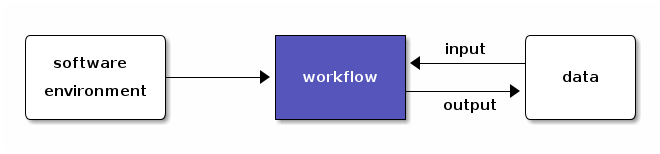

It is a good idea to keep *everything* related to a given project in one
single folder.

See [Good Enough Practices in Scientific
Computing](https://arxiv.org/abs/1609.00037) for a more extended
discussion and for further recommendations on how to shape your
computational projects.

### Reproducible research

Carring out **reproducible research** means putting a colleague in the
conditions to re-obtain our results

-   in actual experiments: within **statistical uncertainty**
-   in computer experiments and numerical analysis: typically
    **statistical uncertainty**, but sometimes even within **numerical
    precision**

*References*:

-   <https://rlhick.people.wm.edu/posts/reproducible-research.html>
-   <http://faculty.washington.edu/rjl/talks/csgf08/csgf08.pdf>

**Reproducibility** is achieved by providing

-   workflow documentation
-   output results
-   (optionally) software environment description
-   (optionally) input data


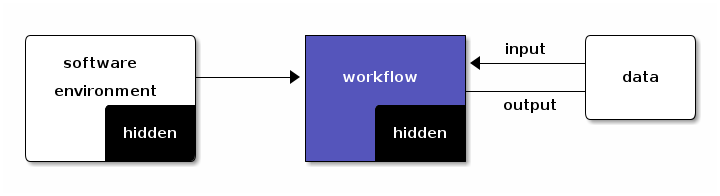

**\"Full reproducibility\"** (or \"replicability\") is achieved by
providing the full project stack

-   software environment
-   workflow
-   data

|  | **Reproducibility** | **Full reproducibility** |
|----|----|----|
| **Pros** | Tests whether results are robust | Reproduces the results exactly |
| **Cons** | Contains hidden variables | Does not ensure results are correct |

As an example of what can go wrong, check out [this nice
article](https://physicstoday.scitation.org/do/10.1063/PT.6.1.20180822a/full/)
on Physics Today about the \"**war over supercooled water**\"
(2010-2017) - a long-standing and harsh controversy on the phase diagram
of water as obtained from computer simulations.

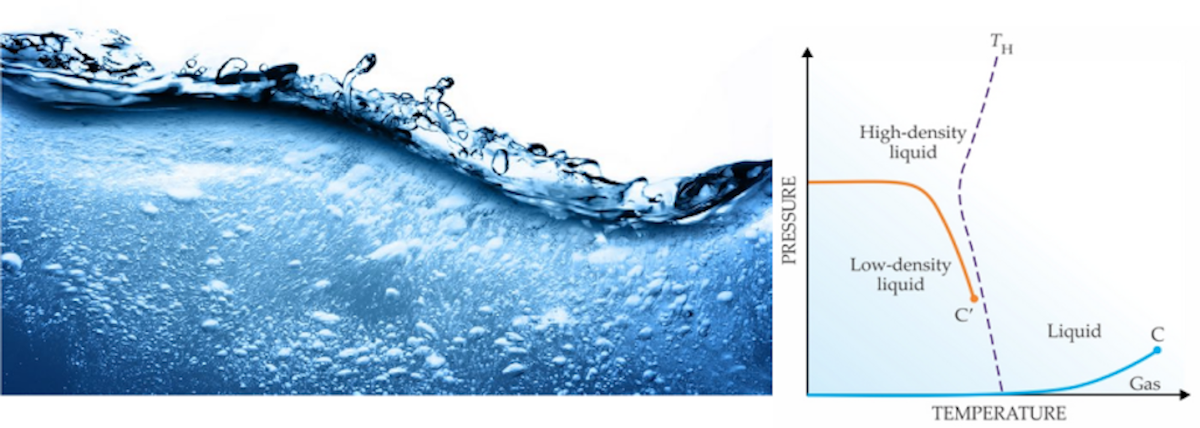

**Morals of the story**:

-   accurate workflow description matters more than reproducibility *per
    sè*
-   sharing of data and workflow is crucial

### My own reproducible research: a lesson hard-learned

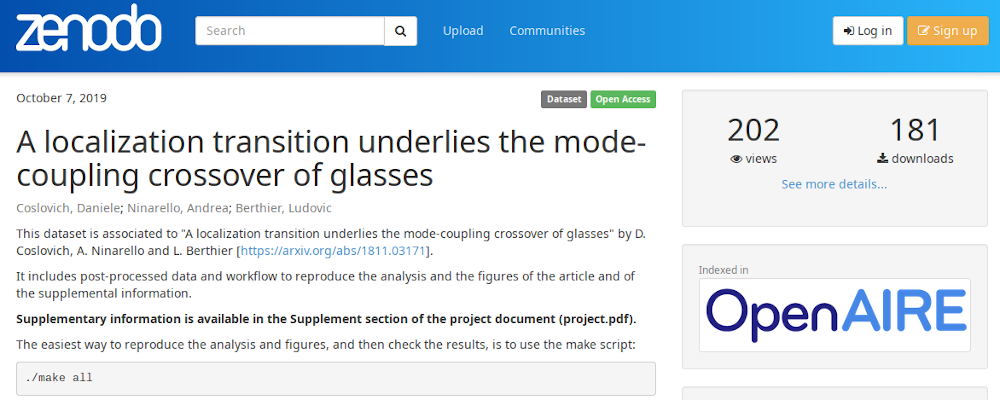

-   Automated reproduction and validation of data/plots
-   Workflow documentation via [Org-mode](https://org-mode.org)
-   Store datasets as [Zenodo](https://zenodo.org/) records
    -   <https://doi.org/10.5281/zenodo.1478600> \[2019\]
    -   <https://doi.org/10.5281/zenodo.6108958> \[2021\]
    -   <https://doi.org/10.5281/zenodo.7296251> \[2022\]
    -   <https://doi.org/10.5281/zenodo.11443197> \[2025\]
-   Provide [Docker](https://www.docker.com/) images for full
    reproducibility
-   Develop my own [workflow and data
    manager](https://framagit.org/coslo/pantarei)
-   Export the project document [as a
    webpage](https://leonardogalliano.frama.io/find_onset/) using sphinx

**Moral of the story**: fully reproducible research is time consuming!

### Workflow management

-   **Workflow** = set of (possibly dependent) **tasks**
-   Describe all the steps needed to replicate the results of your work
-   Integrate the necessary code directly in a **notebook**

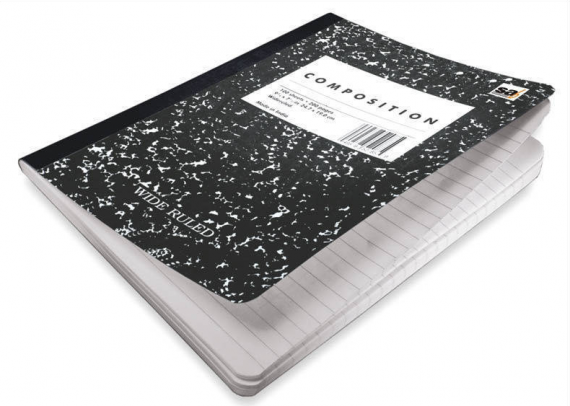

A simple, typical workflow for computational projects


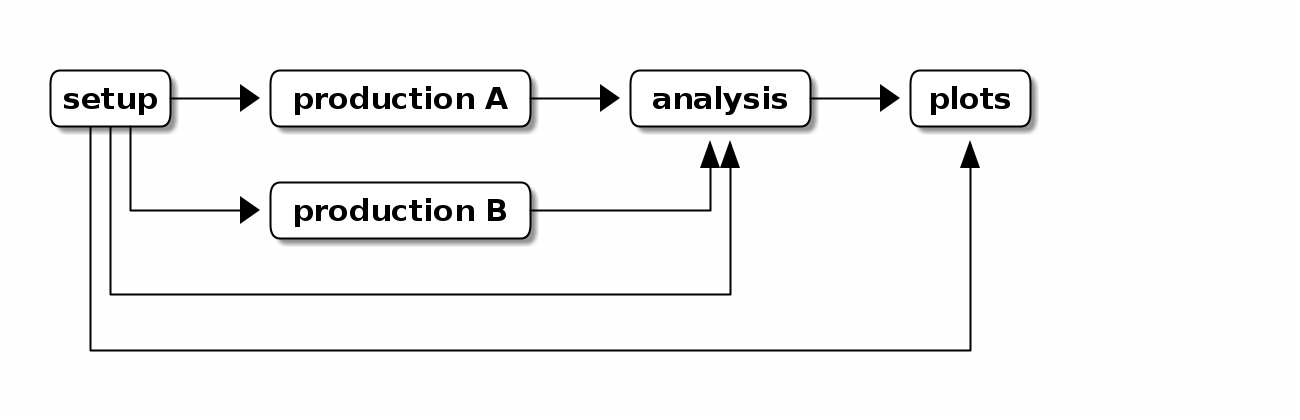

**Pipelining** is the process of executing dependent tasks in the
expected order. Several pipelines can be execute in parallel as long as
their tasks are independent. When a pipeline is executed a second time,
we expect that completed tasks are skipped to save time, for instance
through [memoization](https://en.wikipedia.org/wiki/Memoization).

A [directed acyclic
graph](https://en.wikipedia.org/wiki/Directed_acyclic_graph) (DAG)
provides a representation of the majority of computational workflows. In
a graph representation of the workflow, tasks are connected by arrows
indicating their dependence. No loops are allowed (cycles). A DAG can be
\"topologically ordered\" and this order forms the basis to execute the
pipelines.

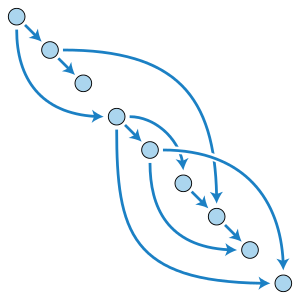

This is our minimal computational workflow sorted in topological order:


In [ ]:
from graphlib import TopologicalSorter

graph = {"setup": {}, 
         "production_A": {"setup"}, 
         "production_B": {"setup"}, 
         "analysis": {"production_A", "production_B"},
         }
ts = TopologicalSorter(graph)
' => '.join(ts.static_order())

Sophisticated high-livel frameworks for workflow mangement and
pipelining:

-   [aiida](https://www.aiida.net/): automated workflows for
    computational science (oriented towards materials science, but not
    limited to that)
-   [fireworks](https://materialsproject.github.io/fireworks/): free,
    open-source code for defining, managing, and executing workflows.
-   [signac](https://docs.signac.io/en/latest/): framework to manage
    project-related data
-   [sumatra](https://pythonhosted.org/Sumatra/index.html): tool for
    managing and tracking projects based on numerical simulation and/or
    analysis
-   [sacred](https://sacred.readthedocs.io/en/stable/): tool to
    configure, organize, log and reproduce computational experiments
    (with a focus on ML).

Data-science oriented platforms (typically freemium):
[prefect](https://www.prefect.io/), [wandb](https://wandb.ai/site),
[MLFlow](https://mlflow.org/), ...

To illustrate the underlying ideas, we will explore instead a few
simpler approaches to workflow management, where it is assumed that the
workflow is defined *implicitly* by the notebook and/or by the scripts.

### A minimal simulation workflow

Let us suppose that our simulation workflow comprises the following
steps:

-   **production**: run a simulation using a `run()` driver,
    which returns some thermodynamic data
-   **analysis**: postprocess the data and compute some stats using a
    `postprocess()` function
-   **plot**: plot some graphs using the above data with some
    `plot()` function

We emulate this setup with these functions


In [4]:
import time
import numpy
from pprint import pprint

def run(T=1.0, n=12, seed=1):
    import numpy.random
    # Emulate some long running simulation...
    time.sleep(2)
    # Return some synthetic thermodynamic data
    numpy.random.seed(seed)
    raw = numpy.random.normal(size=1000)
    data = {'U': 3/2 * T * raw, 'W': T + raw * n/3}
    return data

def postprocess(data):
    results = {}
    # Compute stats
    for key in data:
        results[f'mean_{key}'] = numpy.mean(data[key])
        results[f'std_{key}'] = numpy.std(data[key])
    # Compute virial-potential energy correlation
    R = numpy.corrcoef(data['U'], data['W'])[0, 1]
    results[f'correlation_UW'] = R
    return results

def plot(data, results):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(ncols=2)
    for i, key in enumerate(['U', 'W']):
        mean = results[f'mean_{key}']
        ax[i].hist(data[key], histtype='step')
        ax[i].set_title(f'{key} [mean={mean:.2f}]', fontsize='medium')
        ax[i].set_xlabel(f'{key}')
    # fig.savefig('images/UW.svg')

Let\'s run the workflow


{'correlation_UW': 1.0,
 'mean_U': 0.05821871423940277,
 'mean_W': 1.1552499046384073,
 'std_U': 1.4715062008983175,
 'std_W': 3.9240165357288466}


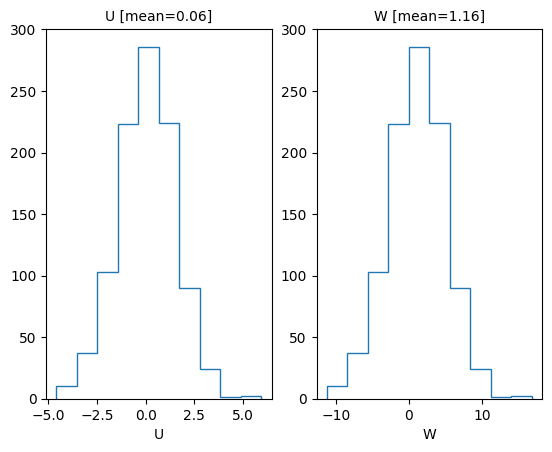

In [5]:
data = run()
results = postprocess(data)
pprint(results)
plot(data, results)

****Note****: The choice to compute the correlation between potential
energy and virial is not accidental!


One issue is that if we execute again the script or notebook, the
`run()` function will carry out the simulation again - even
though nothing has changed! **How do we skip the tasks that have been
already completed?**

### Joblib

A simple and yet powerful Python package for managing tasks is
[joblib](https://joblib.readthedocs.io/en/latest/). The key idea is to
[decorate](https://realpython.com/primer-on-python-decorators/) the
functions defining the workflow (`production`,
`analysis`, `plots, ...`) so that their execution
is skipped if the task is already completed (\"memoization\"). Here, we
will cover only the basics of `joblib`: check out the
[documentation](https://joblib.readthedocs.io/en/latest/) for more
details.

1.  Caching function execution

    To illustrate how joblib works, we will start with a basic example


In [6]:
import time

def square(x):
    time.sleep(2)
    return x**2

We create a `Memory` instance, which contains the joblib
cache, and
[decorate](https://realpython.com/primer-on-python-decorators/) the
`square` function with `memory.cache`.


In [9]:
from joblib import Memory

# The joblib cache is stored in the .joblib/ folder
memory = Memory('.joblib')
square = memory.cache(square)

Call the function a first time


In [12]:
for x in [1, 2]:
    square(x)

________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-1463179676.square...
square(1)
___________________________________________________________square - 2.1s, 0.0min


If we call it again, joblib will look up the results of `run`
stored in the cache.


In [15]:
print(square(2))

4


Now we get back to our simulation workflow. We decorate the
`run` function, as we did before with `square,`
and use the same folder to store the cache. We do not cache the other
functions


In [16]:
from joblib import Memory

memory = Memory('.joblib')
run = memory.cache(run)
data = run()
results = postprocess(data)
pprint(results)

________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-2102313367.run...
run()
______________________________________________________________run - 2.0s, 0.0min
{'correlation_UW': 1.0,
 'mean_U': 0.05821871423940277,
 'mean_W': 1.1552499046384073,
 'std_U': 1.4715062008983175,
 'std_W': 3.9240165357288466}


Now we can change the postprocess function and call again the above
block without running again the simulation!

You can decorate the functions you want to cache using the Python
[decorator syntax](https://realpython.com/primer-on-python-decorators/)


In [17]:
@memory.cache()
def run():
    time.sleep(2.0)

In the same vein, we could cache the `postprocess` results as
well, especially if that is taking some time to rexecute.


****Question****: What happens if you edit the body of the cached
function?


Embarassing parallelism

It is possible to [run the joblib-decorated function in
parallel](https://joblib.readthedocs.io/en/latest/parallel.html) for
different combinations of input parameters. This is useful only for
**embarassingly parallel** tasks, with no dependence between between
each other.


In [ ]:
import time

def cube(x):
    time.sleep(2)
    return x**3

(<function cube at 0x7f77941d6f80>, (2,), {})


To achieve this, we decorate the function with the `delayed`
decorator, which defers execution of the function, and then pass a list
of such delayed functions to a `Parallel` object


In [ ]:
import time
import joblib

func = joblib.delayed(cube)
t0 = time.time()
joblib.Parallel(n_jobs=-1)(func(x) for x in [1, 2])
t1 = time.time()
print(f'Elapsed time = {t1 - t0:.2f} s')

The `njobs` argument controls the number of cores over which
the calculation is distributed. Note that by default only 1 core is
used! A value of -1 will exploit all available cores.


In [7]:
t0 = time.time()
joblib.Parallel()(func(x) for x in [1, 2])
t1 = time.time()
print(f'Elapsed time = {t1 - t0:.2f} s')

Elapsed time = 4.00 s


It can be more flexibile to first assemble a list of function calls and
then pass them to `Parallel`


In [6]:
tasks = [func(x) for x in [1, 2]]
joblib.Parallel(n_jobs=-1)(tasks)

[1, 8]

Of course, you can decorate the function with both `delayed`
and `cache`, to avoid re-execution.


In [27]:
memory = joblib.Memory('.joblib')
func = joblib.delayed(memory.cache(cube))
joblib.Parallel(n_jobs=-1)(func(x) for x in [1, 2])

[1, 8]

****Note****: Parallel execution is done in the shared memory
environment of your processor using [processes or
threads](https://joblib.readthedocs.io/en/latest/parallel.html#thread-based-parallelism-vs-process-based-parallelism).
Joblib has no native support for parallel execution on distributed
memory environments, such as HPC clusters. It can be interfaced to
[dask](https://www.dask.org), a sophisticated (but fairly complex)
workflow manager for distributed environements. See [this
example](https://joblib.readthedocs.io/en/latest/auto_examples/parallel/distributed_backend_simple.html).


Before continuing, let\'s clear the decorated function. In a jupyter
notebook, it is better to restart the kernel now.


In [ ]:
del run

### Pantarei

Joblib is a great package. However, it has some **limitations**:

-   **cosmetic changes** to code triggers re-execution
-   no *native* support for **distributed computing**
-   no easy way to **browse** the cache and collect **datasets**

To address these issues and more, I created
[pantarei](https://framagit.org/coslo/pantarei), a simple but
general-purpose data and workflow manager. It is still under active
development, but the basic features should work fine!

To try it out, you can install it from pip


In [ ]:
! pip install pantarei

To install the latest version from the git repository


In [ ]:
! pip install pantarei@git+https://framagit.org/coslo/pantarei.git

Pantarei builds on four kinds of execution units:

-   **functions**: stateless, Python callables
-   **tasks**: wrapped functions that cache execution results
-   **threads**: wrapped tasks for batch execution in *shared-memory*
    parallel environments
-   **jobs**: wrapped tasks for batch execution in *distributed-memory*
    parallel environments

As a catch-all, it also provides a **parallel** execution unit that uses
whatever scheduling system is available on your environment, defaulting
to shared-memory parallelism.

Caching function execution

Let\'s start with the same Python function we used before


In [26]:
import time

def square(x):
    time.sleep(2)
    return 1 + x**2

Pretty much like joblib, `pantarei` caches the execution of
functions, but using *classes* instead of *decorators* to do the
wrapping. Here, we wrap the `square` function with a
`Task` and call it with a range of arguments


In [ ]:
import pantarei as rei

task = rei.Task(square)
for x in [1, 2, 3]:
    print(task(x=x))

The task\'s results are cached: a successive execution will just fetch
the results


In [21]:
print(square(x=1))

2


Getting back to our simulation workflow, it will go like this


{'correlation_UW': 1.0,
 'mean_U': 0.05821871423940277,
 'mean_W': 1.1552499046384073,
 'std_U': 1.4715062008983175,
 'std_W': 3.9240165357288466}


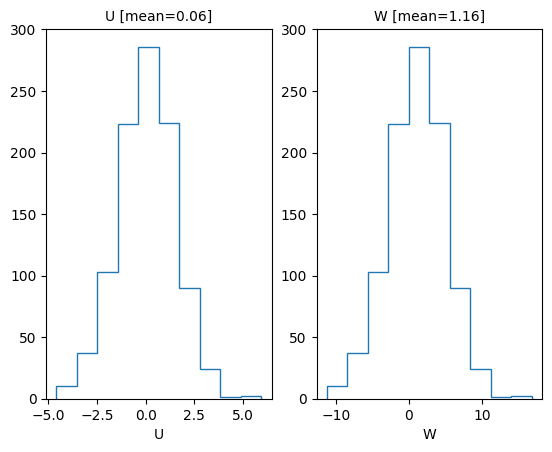

In [12]:
import time
import numpy
from pprint import pprint

def run(T=1.0, n=12, seed=1):
    import numpy.random
    # Emulate some long running simulation...
    time.sleep(2)
    # Return some synthetic thermodynamic data
    numpy.random.seed(seed)
    raw = numpy.random.normal(size=1000)
    data = {'U': 3/2 * T * raw, 'W': T + raw * n/3}
    return data

def postprocess(data):
    results = {}
    # Compute stats
    for key in data:
        results[f'mean_{key}'] = numpy.mean(data[key])
        results[f'std_{key}'] = numpy.std(data[key])
    # Compute virial-potential energy correlation
    R = numpy.corrcoef(data['U'], data['W'])[0, 1]
    results[f'correlation_UW'] = R
    return results

def plot(data, results):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(ncols=2)
    for i, key in enumerate(['U', 'W']):
        mean = results[f'mean_{key}']
        ax[i].hist(data[key], histtype='step')
        ax[i].set_title(f'{key} [mean={mean:.2f}]', fontsize='medium')
        ax[i].set_xlabel(f'{key}')
    # fig.savefig('images/UW.svg')
data = rei.Task(run)()
results = postprocess(data)
pprint(results)
plot(data, results)

****Question****: What if you edit now the function `square`{.verbatim}?
Compare with the joblib behavior!


To always clear the cache of a `Task` before execution, use
the `clear_first` argument of the `Task`
constructor (this is useful while debugging a code). You can always
remove the folder `.pantarei` to forcefully remove the cache.

Embarassing parallelism

With `pantarei`, it is easy to run tasks for different
combinations of input parameters on either a multi-core machine, as your
laptop, or on a distributed computing environment, such as an HPC
cluster. This latter option allows your code to run in parallel over
many more cores than on a single shared-memory environment of your
processor.

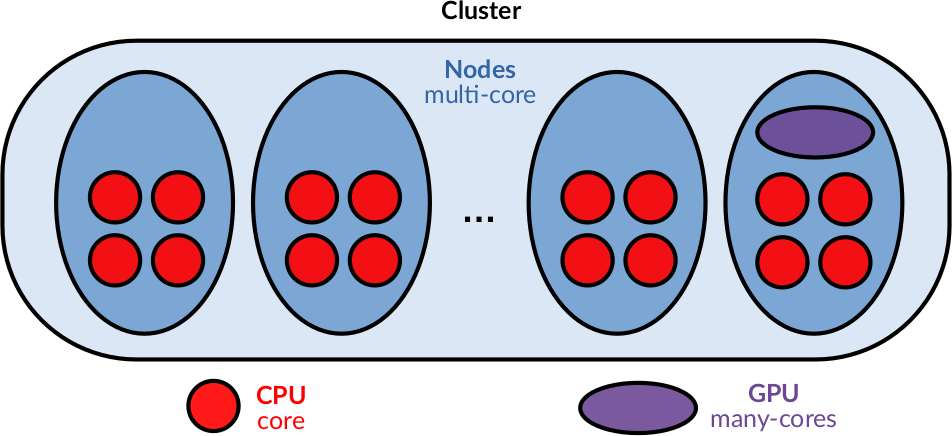

To achieve this, you need a scheduler (ex. SLURM) installed on the
machine you are running your code. If you have access to an HPC cluster,
execute your workflow over there: pantarei will auto-detect the
scheduler. Otherwise, it will fallback to parallel execution on your
multi-core processor.

We can now wrap the function with `Parallel` and submit the
task to the default scheduler for parallel execution


In [31]:
# from pantarei import Parallel

job = rei.Parallel(square)
for x in [1154, 1515, 1016]:
    print(job(x=x))

1331717
2295226
None


In [7]:
def ciao(x):
    time.sleep(5)
    return {'result': x**2}

In [64]:
data = rei.Task(ciao)(2)
print(data)

4


In [8]:
awa = rei.Parallel(ciao)

In [12]:
for i in range(100):
    print(awa(x=i,clear_first=True))

JobFailure: stop because of previous job failure ciao/cf0a60ed11c9c787b13f307437018d75

In [ ]:
dataset = rei.browse('ciao')
dataset.sort('job_end'==Trie)
dataset

clear_first job_end            job_fail           job_queue          job_start          x 
------------------------------------------------------------------------------------------
True        None               1746666414.65...   1746666414.63...   1746666414.64...   0 
None        None               None               None               None               1 
None        1746666364.40...   None               1746666359.35...   1746666359.35...   1 
True        None               1746666414.69...   1746666414.66...   1746666414.67...   1 
None        None               None               None               None               2 
True        None               1746666414.70...   1746666414.68...   1746666414.68...   2 
None        1746666364.48...   None               1746666359.43...   1746666359.44...   3 
True        None               1746666414.70...   1746666414.68...   1746666414.68...   3 
None        1746666364.46...   None               1746666359.44...   1746666359.44...   4 

In [86]:
pantarei.report()

❌ failed   15% [8/55]
✅ ended    85% [47/55]
   ❌ ciao/cf0a60ed11c9c787b13f307437018d75 0:00:00 ciao(x=0,clear_first=True)
   ❌ ciao/f667a224b94c878ccb8d29a922908a8d 0:00:00 ciao(x=1,clear_first=True)
   ❌ ciao/619058058115f62bb087c0eb178930bb 0:00:00 ciao(x=2,clear_first=True)
   ❌ ciao/8956d8658ea26e5b04e41b88ee41ebd7 0:00:00 ciao(x=3,clear_first=True)
   ❌ ciao/a45341feb230d0bf5248362ed65af54d 0:00:00 ciao(x=4,clear_first=True)
   ❌ ciao/6ea94a850196334f93a650d027ebe098 0:00:00 ciao(x=5,clear_first=True)
   ❌ ciao/fdb7abefba2ca15e599899a6c9dda00c 0:00:00 ciao(x=6,clear_first=True)
   ❌ ciao/9e1114534a10eedc94a7722038f3261b 0:00:00 ciao(x=7,clear_first=True)
   ✅ square/216ec88e5485e1ae439c37d3f94cab8f 0:00:02 square(x=1)
   ✅ square/4e17f7f9fc6073c3d511bc12c7b6722a 0:00:02 square(x=2)
   ✅ square/1853daf3a769344e10cfcbdef036a8c9 0:00:02 square(x=3)
   ✅ run/99914b932bd37a50b983c5e7c90ae93b 0:00:02 run(T=1.0,n=12,seed=1)
   ✅ square/c76efa3fc9a27578c87cd8cb8aed25f1 0:00:02 square(x=4

****Warning****: Two current limitations of pantarei `Jobs`{.verbatim}
on a distributed memory environment are: (i) the name of Job instances
must be `job`{.verbatim} and (ii) all arguments to `job`{.verbatim} must
be passed by keyword. Hopefully, they will be removed soon.


The jobs will now run in the background. To see a summary of the jobs in
the current session, execute this or add it at the end of the script.


In [14]:
import pantarei

pantarei.report()

✅ ended   100% [7/7]
   ✅ square/216ec88e5485e1ae439c37d3f94cab8f 0:00:02 square(x=1)
   ✅ square/4e17f7f9fc6073c3d511bc12c7b6722a 0:00:02 square(x=2)
   ✅ square/1853daf3a769344e10cfcbdef036a8c9 0:00:02 square(x=3)
   ✅ run/99914b932bd37a50b983c5e7c90ae93b 0:00:02 run(T=1.0,n=12,seed=1)
   ✅ square/c76efa3fc9a27578c87cd8cb8aed25f1 0:00:02 square(x=4)
   ✅ square/ad2f95190d24933f6a38dc9ff7cf8a57 0:00:02 square(x=5)
   ✅ square/7bae9cd0f3a016f19dcad6fdde400a40 0:00:02 square(x=6)


In this case, the jobs were already over! You can also see the status of
the jobs using the scheduler from the command line, using the
`rei` command.

Once the jobs are done, we can get the actual results.


In [15]:
job.scheduler.wait()
results = job(x=6)

****Note****: Jobs and tasks share the same cache. Therefore, calling a
`Job`{.verbatim} or a `Thread`{.verbatim} that wraps a `Task`{.verbatim}
that has been already called will not trigger a resubmission.


Browsing datasets

The tasks arguments and results are stored in cache in a way similar to
joblib. However, pantarei provides eacy access to the **tasks\'
datasets** through dedicated `Dataset` and `Data`
objects. The syntax of `Dataset` is inspired by the one of
dataframes in [pandas](https://pandas.pydata.org/) - a popular package
for data science.

Let\'s make some simulations for a range of parameters


In [16]:
import time
import numpy
from pprint import pprint

def run(T=1.0, n=12, seed=1):
    import numpy.random
    # Emulate some long running simulation...
    time.sleep(2)
    # Return some synthetic thermodynamic data
    numpy.random.seed(seed)
    raw = numpy.random.normal(size=1000)
    data = {'U': 3/2 * T * raw, 'W': T + raw * n/3}
    return data

def postprocess(data):
    results = {}
    # Compute stats
    for key in data:
        results[f'mean_{key}'] = numpy.mean(data[key])
        results[f'std_{key}'] = numpy.std(data[key])
    # Compute virial-potential energy correlation
    R = numpy.corrcoef(data['U'], data['W'])[0, 1]
    results[f'correlation_UW'] = R
    return results

def plot(data, results):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(ncols=2)
    for i, key in enumerate(['U', 'W']):
        mean = results[f'mean_{key}']
        ax[i].hist(data[key], histtype='step')
        ax[i].set_title(f'{key} [mean={mean:.2f}]', fontsize='medium')
        ax[i].set_xlabel(f'{key}')
    fig.savefig('images/UW.svg')
from pantarei import Task

run = Task(run)
pp = postprocess

for T in [1.0, 2.0, 3.0]:
    for seed in range(2):
        data = run(T=T, seed=seed)
        pp(data)

We can now browse all the arguments and results as a \"dataset\"


In [17]:
from pantarei.core import browse
browse('run')

T   U                    W                    n  seed
-----------------------------------------------------
1.0 [ 2.43651805e+00 ... [ 7.49738145e+00 ... 12 1   
1.0 [ 2.64607852e+00 ... [ 8.05620938e+00 ... 12 0   
1.0 [ 2.43651805e+00 ... [ 7.49738145e+00 ... 12 1   
2.0 [ 5.29215704e+00 ... [ 9.05620938e+00 ... 12 0   
2.0 [ 4.87303609e+00 ... [ 8.49738145e+00 ... 12 1   
3.0 [ 7.93823556e+00 ... [ 1.00562094e+01 ... 12 0   
3.0 [ 7.30955414e+00 ... [ 9.49738145e+00 ... 12 1   

The returned dataset is a `Dataset` object with
`pandas`-like features


In [18]:
dataset = browse('run')
print(dataset.columns())
print(dataset['T'])

['T', 'U', 'W', '_dirname', '_path', 'n', 'seed']
[1. 1. 1. 2. 2. 3. 3.]


****Note****: You can always inspect the cache by looking inside the
`.pantarei/`{.verbatim} folder. Clearing the cache \"manually\" is fine,
too.


We can create a `Dataset` explictly by providing paths and
parsers


In [19]:
from pantarei import Dataset

dataset = Dataset(parsers=[('pickle', '*.pkl')])
dataset.insert('.pantarei/run/**')
dataset

T   U                    W                    n  seed
-----------------------------------------------------
2.0 [ 5.29215704e+00 ... [ 9.05620938e+00 ... 12 0   
1.0 [ 2.43651805e+00 ... [ 7.49738145e+00 ... 12 1   
1.0 [ 2.64607852e+00 ... [ 8.05620938e+00 ... 12 0   
3.0 [ 7.93823556e+00 ... [ 1.00562094e+01 ... 12 0   
1.0 [ 2.43651805e+00 ... [ 7.49738145e+00 ... 12 1   
3.0 [ 7.30955414e+00 ... [ 9.49738145e+00 ... 12 1   
2.0 [ 4.87303609e+00 ... [ 8.49738145e+00 ... 12 1   

Actually, `browse` parses any files it finds in tabular, yaml
or pickle format to populate the dataset. If your simulation code store
artifacts in subfolders, you can quickly create and analyze them using
Datasets!

As an example, we parse the dataset of your analysis of the second
virial coefficient


In [ ]:
from pantarei import Dataset

Dataset('./data/eos/*/*.yaml')

Ops... some files are missing because they have an unconventional
suffix.


In [ ]:
from pantarei import Dataset
ds = Dataset(parsers=[('yaml', '*.yaml'),
                      ('yaml', '*.yml')])
ds.insert('./data/eos/*/*.yaml')
ds.insert('./data/eos/*/*.yml')
ds.sort('epsilon')
ds

Not totally happy with how the parameters are formatted, so we add a
\"hook\" to fix them.


In [ ]:
def fix(entry):
    entry['system'] = entry['system'].lower()
    if entry['model'] == 'Lennard-Jones':
        entry['model'] = 'LJ'
    return entry

from pantarei import Dataset
ds = Dataset(parsers=[('yaml', '*.yaml'), ('yaml', '*.yml')])
ds.add_hook(fix)
ds.insert('./data/eos/*/*.yaml')
ds.insert('./data/eos/*/*.yml')
ds.sort('epsilon')
ds

For more information, check out the [pantarei
documentation](https://coslo.frama.io/pantarei/).
